# Task:
### You must create a model which predicts a probability of each type of toxicity for each comment.



https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
# Reading train and test data

path = 'C:/Users/USER/Desktop/Coventry University/Fall/7120CEM - Natural Language Processing - 2324SEPJAN/Coursework/CW In Progress/Toxic Comments CW attempt'
df_train = pd.read_csv(path+'/train.csv')
df_test = pd.read_csv(path+'/test.csv')


In [3]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_train.loc[:,'toxic':'identity_hate'].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [5]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
comments = df_train['comment_text']
comments

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [7]:
comments[3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [8]:
# showing most frequent words before cleaning

from collections import Counter

comments_data = ' '.join(comments)

words = comments_data.split()

word_counter = Counter(words)

# top 10 most common words and their frequencies
top_words = word_counter.most_common(30)

for word, frequency in top_words:
    print(f'{word}: {frequency}')


the: 445987
to: 288817
of: 219334
and: 207381
a: 201817
I: 183930
is: 164639
you: 157272
that: 140545
in: 130262
for: 96010
it: 92651
on: 84453
not: 83944
": 81755
be: 80928
this: 71429
have: 69414
as: 68345
are: 66277
with: 56471
your: 55802
was: 52875
or: 48019
but: 42472
an: 41976
The: 39578
from: 39075
my: 38622
by: 38562


In [10]:
# defining a function that returns the strings (certain strings i want to exclude) i am looking for
def find_string(s, search_string):
    if search_string in s:
        return search_string
    else:
        return None

In [11]:
# searching for some random strings that i intend to remove later on

search_strings = ['www.', '.com', 'yahoo', 'hotmail', 'gmail',
                  '<', '#', 'username', 'Username', 'RT', ':)', '  ']

def find_strings(comment, substrings):
    matching_substrings = [substring for substring in substrings if substring in comment]
    return ', '.join(matching_substrings) if matching_substrings else None

results = comments.apply(find_strings, substrings=search_strings)

unique_results = results[results.notna()].unique()

print(*unique_results, sep='\n')


#### This shows that we have elements related to websites and emails which we have to remove,
#### in additon to other special characters to be removed

username
  
#,   
www., #
.com, #,   
www.,   
username,   
www., .com
.com, #
www.
.com,   
#
www., .com,   
RT
#, username,   
Username,   
RT,   
.com, :)
.com
<, #,   
.com, gmail,   
:),   
.com, username
.com, username,   
:)
www., .com, #
www., #,   
www., .com, #,   
Username
yahoo
.com, RT
#, RT,   
.com, RT,   
gmail
<,   
.com, hotmail
www., .com, RT
www., username
.com, gmail
yahoo,   
<
.com, yahoo
#, Username,   
www., .com, #, RT,   
.com, #, RT
#, RT
#, :),   
www., .com, RT,   
www., <,   
hotmail
.com, yahoo, <
#, username, Username,   
www., .com, <,   
www., .com, hotmail
www., RT,   
.com, yahoo, RT,   
www., .com, yahoo
.com, yahoo, hotmail
www., .com, yahoo,   
.com, hotmail,   
.com, hotmail, RT
username, Username
#, username
.com, <
.com, :),   
username, Username,   
.com, <,   
www., .com, gmail
.com, yahoo, username
www., .com, :),   
www., .com, <
www., gmail,   
.com, yahoo,   
www., .com, gmail, RT,   
www., .com, #, username
www., .com, yahoo, hotmail,  

# Cleaning Data

In [12]:
def clean_comment(comment):
    comment = comment.lower()
    comment = re.sub(r"what's", "what is ", comment)
    comment = re.sub(r"\'s", " ", comment)
    comment = re.sub(r"\'ve", " have ", comment)
    comment = re.sub(r"can't", "cannot ", comment)
    comment = re.sub(r"n't", " not ", comment)
    comment = re.sub(r"i'm", "i am ", comment)
    comment = re.sub(r"\'re", " are ", comment)
    comment = re.sub(r"\'d", " would ", comment)
    comment = re.sub(r"\'ll", " will ", comment)
    comment = re.sub(r"\'scuse", " excuse ", comment)
    comment = re.sub('\W', ' ', comment)
    comment = re.sub('\s+', ' ', comment)
    comment = comment.strip(' ')
    return comment

In [13]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(comment):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # double spacing
    comment = comment.str.replace(r'\s+', ' ', regex=True)
    
    # replacing strings with empty strings
    comment = comment.str.replace(r'username|gmail|hotmail|yahoo', '', regex=True)
    comment = comment.str.replace(r'\bim\b', 'i am', regex=True)

    # removing html tags and urls
    comment = comment.str.replace(r'<[^>]+>', '', regex=True)
    comment = comment.str.replace(r'http\S+', '', regex=True)

    # removing non-alphabetic chars and nums
    comment = comment.str.replace(r'[^a-zA-Z\s]', '', regex=True)
    comment = comment.str.replace(r'\d+', '', regex=True)

    # tokenization
    comment = comment.apply(nltk.word_tokenize)

    # lemmatization
    comment = comment.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

    comment = comment.apply(lambda tokens: ' '.join(tokens))

    return comment



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# removing emojis
def remove_emoji(comment):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols and pictographs
                           u"\U0001F680-\U0001F6FF"  # transport and map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags for iOS
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    comment=emoji_clean.sub(r'',comment)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    comment=url_clean.sub(r'',comment)
    return comment

In [15]:
# cleaning text using all previous 3 preprocessing functions

comments_clean = comments.apply(clean_comment)
comments_clean = preprocess_text(comments_clean)
comments_clean = comments_clean.apply(remove_emoji)
print(comments_clean)

0         explanation edits made hardcore metallica fan ...
1         aww match background colour seemingly stuck th...
2         hey man really trying edit war guy constantly ...
3         make real suggestion improvement wondered sect...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm there actual article prostitution ...
159569    look like actually put speedy first version de...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object


In [16]:
## running our search function again to see if we cleaned the strings we searched for previously

results = comments_clean.apply(find_strings, substrings=search_strings)

unique_results = results[results.notna()].unique()

print(*unique_results, sep='\n')

#### looks like we achieved our target in removing unwanted strings

In [19]:
# showing most frequent words after cleaning

from collections import Counter

comments_clean_data = ' '.join(comments_clean)

words_clean = comments_clean_data.split()

word_counter = Counter(words_clean)

# top 20 most common words and their frequencies
top_words = word_counter.most_common(20)

for word, frequency in top_words:
    print(f'{word}: {frequency}')


article: 74403
page: 57206
wikipedia: 48455
talk: 37419
would: 36753
one: 30740
please: 29796
like: 28434
see: 21782
source: 21773
think: 20768
also: 20641
know: 20162
time: 19267
people: 18937
edit: 18293
user: 17976
use: 16594
make: 16235
may: 15623


In [20]:
top_words

[('article', 74403),
 ('page', 57206),
 ('wikipedia', 48455),
 ('talk', 37419),
 ('would', 36753),
 ('one', 30740),
 ('please', 29796),
 ('like', 28434),
 ('see', 21782),
 ('source', 21773),
 ('think', 20768),
 ('also', 20641),
 ('know', 20162),
 ('time', 19267),
 ('people', 18937),
 ('edit', 18293),
 ('user', 17976),
 ('use', 16594),
 ('make', 16235),
 ('may', 15623)]

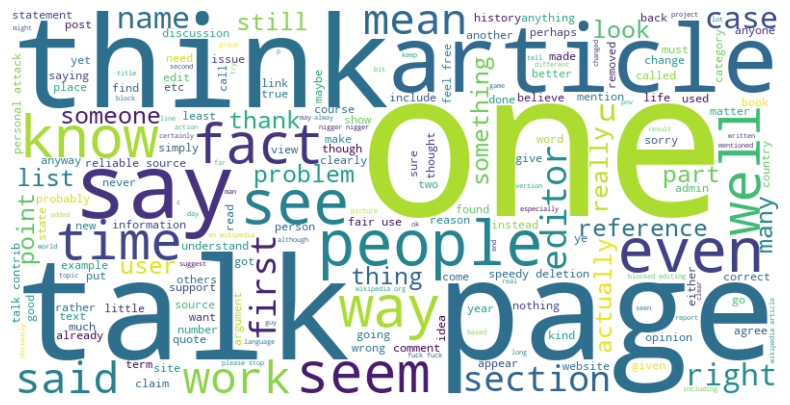

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# combining all the text from the Pandas Series into a single string
combined_text = " ".join(comments_clean)

# generating word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Top 5 Correlated Features (X): ['obscene' 'insult' 'obscene' 'toxic' 'insult']
Target Variables (Y): ['insult' 'obscene' 'toxic' 'obscene' 'toxic']
Correlation Values: [0.74127244 0.74127244 0.67651452 0.67651452 0.64751813]


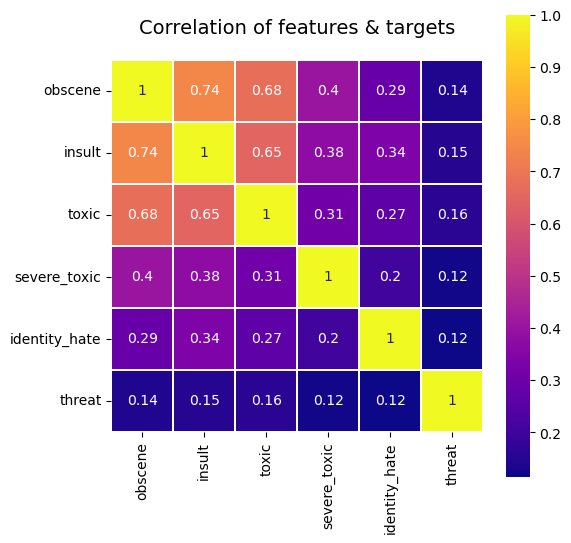

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
cols_target = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
data_plot = df_train[cols_target]

# calculating correlation matrix
corr_matrix = data_plot.corr()

# top 5 correlated pairs
top_corr = corr_matrix.abs().stack().reset_index()
top_corr.columns = ['X', 'Y', 'Correlation']
top_corr = top_corr[top_corr['X'] != top_corr['Y']].sort_values(by='Correlation', ascending=False).head(5)
top_x = top_corr['X'].values
top_y = top_corr['Y'].values
top_correlation_values = top_corr['Correlation'].values

print("Top 5 Correlated Features (X):", top_x)
print("Target Variables (Y):", top_y)
print("Correlation Values:", top_correlation_values)

# heatmap
colormap = plt.cm.plasma
plt.figure(figsize=(6, 6))
plt.title('Correlation of features & targets', y=1.05, size=14)
sns.heatmap(data_plot.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap,
            linecolor='white', annot=True)

plt.show()


In [24]:
from sklearn.model_selection import train_test_split

# defining the features X and their target labels y
X = comments_clean
y = df_train[cols_target]

# 80 train, 20 validation split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)


X_train shape: (127656,)
X_valid shape: (31915,)
y_train shape: (127656, 6)
y_valid shape: (31915, 6)


In [25]:
print(X_train[2])

hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info


In [26]:
# BASED ON PREVIOUS TEST ON NGRAM 1,3 AND 2,2, BEST METRICS WERE ACHEIVED BY NGRAM_RANGE 1,2
# THATS WHY I CHOSE TO STICK WITH NGRAM_RANGE (1,2)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))


X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_valid_tfidf = tfidf_vectorizer.transform(X_valid)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_valid_tfidf shape:", X_valid_tfidf.shape)


X_train_tfidf shape: (127656, 10000)
X_valid_tfidf shape: (31915, 10000)


# Multinomial Naive Bayes 

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# training a multi-label classifier
classifier = MultiOutputClassifier(MultinomialNB())
classifier.fit(X_train_tfidf, y_train)

# making predictions on validation data
y_pred = classifier.predict(X_valid_tfidf)

# calculating accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy:", accuracy)

# generating a classification report (optional)
report = classification_report(y_valid, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.912486291712361
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.51      0.65      1715
           1       0.82      0.43      0.56      1614
           2       0.90      0.52      0.66      3056
           3       0.59      0.17      0.26       321
           4       0.50      0.05      0.09       294
           5       0.00      0.00      0.00        74

   micro avg       0.87      0.45      0.60      7074
   macro avg       0.62      0.28      0.37      7074
weighted avg       0.84      0.45      0.59      7074
 samples avg       0.05      0.04      0.04      7074



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, zero_one_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer


MOC_logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000))

MOC_logreg.fit(X_train_tfidf, y_train)

y_pred = MOC_logreg.predict(X_valid_tfidf)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy:", acc)


# classification report
scorer = make_scorer(zero_one_loss, greater_is_better=False, zero_division=1)
report = classification_report(y_valid, y_pred, target_names=y_valid.columns, zero_division=1)

print("Classification Report:\n", report)


Accuracy: 0.9195989346702178
Classification Report:
                precision    recall  f1-score   support

      obscene       0.92      0.63      0.75      1715
       insult       0.82      0.51      0.63      1614
        toxic       0.91      0.62      0.73      3056
 severe_toxic       0.54      0.24      0.33       321
identity_hate       0.77      0.17      0.28       294
       threat       0.55      0.08      0.14        74

    micro avg       0.88      0.55      0.68      7074
    macro avg       0.75      0.37      0.48      7074
 weighted avg       0.86      0.55      0.67      7074
  samples avg       0.99      0.95      0.95      7074



In [ ]:
# # ngram 1,2 (from the above)

# Accuracy: 0.9195989346702178
# Classification Report:
#                 precision    recall  f1-score   support

#       obscene       0.92      0.63      0.75      1715
#        insult       0.82      0.51      0.63      1614
#         toxic       0.91      0.62      0.73      3056
#  severe_toxic       0.54      0.24      0.33       321
# identity_hate       0.77      0.17      0.28       294
#        threat       0.55      0.08      0.14        74

#     micro avg       0.88      0.55      0.68      7074
#     macro avg       0.75      0.37      0.48      7074
#  weighted avg       0.86      0.55      0.67      7074
#   samples avg       0.06      0.05      0.05      7074

In [ ]:
# # # ngram_range= (1,3)

# Accuracy: 0.9194736017546609
# Classification Report:
#                 precision    recall  f1-score   support

#       obscene       0.92      0.63      0.75      1715
#        insult       0.82      0.51      0.63      1614
#         toxic       0.91      0.62      0.73      3056
#  severe_toxic       0.54      0.23      0.32       321
# identity_hate       0.74      0.17      0.28       294
#        threat       0.55      0.08      0.14        74

#     micro avg       0.87      0.55      0.68      7074
#     macro avg       0.74      0.37      0.48      7074
#  weighted avg       0.86      0.55      0.67      7074
#   samples avg       0.06      0.05      0.05      7074

In [29]:
from sklearn.feature_selection import SelectKBest, chi2

# defining the number of top features
k = 6000 

# feature selection using chi-squared
feature_selector = SelectKBest(chi2, k=k)

X_train_tfidf_selected = feature_selector.fit_transform(X_train_tfidf, y_train)
X_valid_tfidf_selected = feature_selector.transform(X_valid_tfidf)


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'estimator__C': [0.01, 0.1, 1, 5],'estimator__penalty': ['l2']}

MOC_logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# GridSearchCV
grid_search = GridSearchCV(MOC_logreg, param_grid, scoring='f1_macro', verbose=3)

grid_search.fit(X_train_tfidf_selected, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END estimator__C=0.01, estimator__penalty=l2;, score=0.018 total time=   2.2s
[CV 2/5] END estimator__C=0.01, estimator__penalty=l2;, score=0.022 total time=   1.8s
[CV 3/5] END estimator__C=0.01, estimator__penalty=l2;, score=0.020 total time=   2.2s
[CV 4/5] END estimator__C=0.01, estimator__penalty=l2;, score=0.020 total time=   1.7s
[CV 5/5] END estimator__C=0.01, estimator__penalty=l2;, score=0.018 total time=   1.8s
[CV 1/5] END estimator__C=0.1, estimator__penalty=l2;, score=0.257 total time=   3.7s
[CV 2/5] END estimator__C=0.1, estimator__penalty=l2;, score=0.280 total time=   3.7s
[CV 3/5] END estimator__C=0.1, estimator__penalty=l2;, score=0.260 total time=   4.0s
[CV 4/5] END estimator__C=0.1, estimator__penalty=l2;, score=0.277 total time=   3.5s
[CV 5/5] END estimator__C=0.1, estimator__penalty=l2;, score=0.260 total time=   3.1s
[CV 1/5] END estimator__C=1, estimator__penalty=l2;, score=0.489 total time

GridSearchCV(estimator=MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000)),
             param_grid={'estimator__C': [0.01, 0.1, 1, 5],
                         'estimator__penalty': ['l2']},
             scoring='f1_macro', verbose=3)

In [31]:
#  fitting MOC logreg with best params

best_params = grid_search.best_params_
best_C = best_params['estimator__C']
best_penalty = best_params['estimator__penalty']

best_MOC_logreg = MultiOutputClassifier(LogisticRegression(max_iter=1000, C=best_C, penalty=best_penalty))

best_MOC_logreg.fit(X_train_tfidf_selected, y_train)

y_pred = best_MOC_logreg.predict(X_valid_tfidf_selected)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy:", acc)

# classification report on the validation set
from sklearn.metrics import classification_report
report = classification_report(y_valid, y_pred, target_names=y_valid.columns, zero_division='warn')
print("Classification Report:\n", report)


Accuracy: 0.9200689331035563
Classification Report:
                precision    recall  f1-score   support

      obscene       0.89      0.68      0.77      1715
       insult       0.79      0.56      0.65      1614
        toxic       0.88      0.67      0.76      3056
 severe_toxic       0.51      0.28      0.36       321
identity_hate       0.74      0.25      0.38       294
       threat       0.56      0.20      0.30        74

    micro avg       0.84      0.61      0.71      7074
    macro avg       0.73      0.44      0.54      7074
 weighted avg       0.83      0.61      0.70      7074
  samples avg       0.06      0.05      0.05      7074



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### the above has slighly improved my recall scores within acceptable range.
### Let us see if we can further optimize our model metrics by using class imbalance technique

### I will now look into using class weights to handle class imbalance in the multi-label classification

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report



all_labels = y_train.values.ravel()

# compute_class_weight() from sklearn to get class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)

# MOC logistic regression with class weights
best_MOC_logreg_cls_imb = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight={i: class_weights[i] for i in range(len(class_weights))}))

best_MOC_logreg_cls_imb.fit(X_train_tfidf_selected, y_train)

y_pred = best_MOC_logreg_cls_imb.predict(X_valid_tfidf_selected)

acc = accuracy_score(y_valid, y_pred)
print("Accuracy:", acc)

report = classification_report(y_valid, y_pred, target_names=y_valid.columns, zero_division='warn')
print("Classification Report:\n", report)


Accuracy: 0.8086479711734295
Classification Report:
                precision    recall  f1-score   support

      obscene       0.55      0.90      0.69      1715
       insult       0.46      0.90      0.61      1614
        toxic       0.42      0.92      0.58      3056
 severe_toxic       0.30      0.79      0.44       321
identity_hate       0.27      0.69      0.39       294
       threat       0.27      0.55      0.37        74

    micro avg       0.44      0.89      0.59      7074
    macro avg       0.38      0.79      0.51      7074
 weighted avg       0.45      0.89      0.60      7074
  samples avg       0.07      0.09      0.07      7074



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### based on the class imbalance technique results and the results obtained without using this technique, it looks like there's a tradoff between having high precision (but low recall) without class imbalance, and high recall (but low precision) with class imbalance. For that reason, i will continue without class imbalance technique.

# Now i am applying on the test.csv

In [33]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [34]:
### cleaning TEST text

test_comments = df_test['comment_text']

test_comments_clean = test_comments.apply(clean_comment)
test_comments_clean = preprocess_text(test_comments_clean)
test_comments_clean = test_comments_clean.apply(remove_emoji)
print(test_comments_clean)

0         yo bitch ja rule succesful ever whats hating s...
1                                        rfc title fine imo
2                                source zawe ashton lapland
3         look back source information updated correct f...
4                                  anonymously edit article
                                ...                        
153159                totally agree stuff nothing long crap
153160    throw field home plate get faster throwing cut...
153161    okinotorishima category see change agree corre...
153162    one founding nation eu germany law return quit...
153163    stop already bullshit welcome fool think kind ...
Name: comment_text, Length: 153164, dtype: object


In [39]:
tfidf_vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', ngram_range=(1, 2))


# using pre-trained TfidfVectorizer

# fitting train data
tfidf_vectorizer.fit(comments_clean)

# transforming test data
X_test_tfidf = tfidf_vectorizer.transform(test_comments_clean)

In [40]:
# using trained MOC logistic regression for predict_proba
y_test_probabilities = best_MOC_logreg.predict_proba(X_test_tfidf)

In [41]:
y_test_probabilities

[array([[0.82228337, 0.17771663],
        [0.94123778, 0.05876222],
        [0.99376461, 0.00623539],
        ...,
        [0.98247736, 0.01752264],
        [0.97488398, 0.02511602],
        [0.95043979, 0.04956021]]),
 array([[0.97983895, 0.02016105],
        [0.89579908, 0.10420092],
        [0.98475155, 0.01524845],
        ...,
        [0.99486578, 0.00513422],
        [0.94927419, 0.05072581],
        [0.92696586, 0.07303414]]),
 array([[0.8169648 , 0.1830352 ],
        [0.747289  , 0.252711  ],
        [0.98230994, 0.01769006],
        ...,
        [0.97542848, 0.02457152],
        [0.92843401, 0.07156599],
        [0.95658122, 0.04341878]]),
 array([[0.99231622, 0.00768378],
        [0.99828919, 0.00171081],
        [0.99750738, 0.00249262],
        ...,
        [0.99637887, 0.00362113],
        [0.99530794, 0.00469206],
        [0.99545835, 0.00454165]]),
 array([[0.97973036, 0.02026964],
        [0.99692012, 0.00307988],
        [0.99849554, 0.00150446],
        ...,
        [

In [43]:
# reading sample_submission to link text id
sample_submissions=pd.read_csv(path+'/sample_submission.csv')
for i in range(len(sample_submissions)):
    for label in range(1, 7):  
        sample_submissions.loc[i, f"Class_{label}"] = y_test_probabilities[label-1][i][1]

# saving results in a new file
sample_submissions.to_csv('final_sample_submission.csv', index=False)

final_sample_submission=pd.read_csv('final_sample_submission.csv')

# adjusting final data in the required template
CW1 = final_sample_submission
cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']
CW1.drop(cols, axis=1, inplace= True)
col_rename_map = {'Class_1': 'toxic',
                     'Class_2': 'severe_toxic',
                     'Class_3': 'obscene',
                     'Class_4': 'threat',
                     'Class_5': 'insult',
                     'Class_6': 'indentity_hate'}

CW1.rename(columns=col_rename_map, inplace=True)

CW1.to_csv('final_sample_submission.csv')


CW1

,id,toxic,severe_toxic,obscene,threat,insult,indentity_hate
0,00001cee341fdb12,0.177717,0.020161,0.183035,0.007684,0.020270,0.001837
1,0000247867823ef7,0.058762,0.104201,0.252711,0.001711,0.003080,0.016762
2,00013b17ad220c46,0.006235,0.015248,0.017690,0.002493,0.001504,0.000697
3,00017563c3f7919a,0.008670,0.006334,0.004999,0.004488,0.002070,0.000957
4,00017695ad8997eb,0.007210,0.025858,0.046018,0.002534,0.002909,0.001014
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.017968,0.014478,0.056717,0.002656,0.001454,0.000702
153160,fffd7a9a6eb32c16,0.037745,0.004849,0.013479,0.001223,0.008248,0.002694
153161,fffda9e8d6fafa9e,0.017523,0.005134,0.024572,0.003621,0.001051,0.000538
153162,fffe8f1340a79fc2,0.025116,0.050726,0.071566,0.004692,0.001174,0.001843
